# 3D detection from 2D images evaluation


In [1]:
import pickle
import warnings
import numpy as np
import pandas as pd
import math

import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
import json
warnings.filterwarnings('ignore')
%cd /workspaces/bev2seg_2/
#%cd /home/VICOMTECH/agarciaj/GitLab/bev2seg_2

DATA_PATH = "./data/pipeline_3d_evaluations.pkl"

/workspaces/bev2seg_2


## Evaluation Data Structure

```python
data = {
    'scene_name_eval0':{
        'openlabel_path': str,
        'model_config':{
            'scene':{
                'scene_path':...,
                'camera_name': 'CAM_FRONT'
            },
            'semantic':{
                'raw2segmodel_path': ...,
                'bev2segmodel_path': ...,
                'merge_semantic_labels_flag': True,
                'merge_dict': DEFAULT_MERGE_DICT,
            },
            'depth_estimation':{
                'depth_pro_path':...
            },
            'scene_pcd':{
            },
            'instance_scene_pcd':{
                'dbscan_samples': 15,
                'dbscan_eps': 0.1,
                'dbscan_jobs': None,
                'lims': (np.inf, np.inf, np.inf),
                'min_samples_per_instance': 250,
                'max_distance': 50.0,
                'max_height': 2.0
            }
        },
        'eval_config':{
            'camera_depth': 15.0,
            'max_association_distance': 7.0,
            'semantic_types': ['vehicle.car'],
            'ignoring_names': ['ego_vehicle']
        },
        'frames': {
            0: {
                'semantic_type':{
                    'num_gt_objs': 0,
                    'num_dt_objs': 0,
                    
                    'metrics':{
                        'tp': 0,
                        'fp': 0,
                        'fn': 0,
                        'dd': [...],
                        'ded': [...],
                        'IoU_v': [...],
                        'v2v_dist': [...],
                        'bbd': [...]
                    }
                }
            },
            ...
        }
        
    }
}
```

In [2]:
def show_evaluated_models(data:dict):
    evaluations = list(data.keys())
    results = []
    for e in evaluations:
        num_frames      = len(data[e]['frames'].keys())
        eval_config     = data[e]['eval_config']
        model_config    = data[e]['model_config']
        results.append([e, num_frames, json.dumps(eval_config, indent=4), json.dumps(model_config, indent=4)])
    res = tabulate(results, headers=['Evaluation Name', 'Num frames', 'eval_config', 'model_config'])

    print(f"\nSAVED EVALUATIONS IN {DATA_PATH}:")
    print(res)

## Defined Functions

In [3]:
def best_grid_shape(num_plots):
    if num_plots == 1:
        return (1, 1)
    
    best_rows, best_cols = None, None
    min_diff = float('inf')  # Diferencia mínima entre filas y columnas
    
    for cols in range(1, math.ceil(math.sqrt(num_plots)) + 1):
        rows = math.ceil(num_plots / cols)
        diff = abs(rows - cols)  # Queremos minimizar la diferencia filas-columnas
        
        if diff < min_diff:
            min_diff = diff
            best_rows, best_cols = rows, cols
    
    return (best_rows, best_cols)

def get_metric_for_each_gt_obj(data:dict, eval_name:str, metric_name:str):
    assert eval_name in data
    distinct_gt_uids = {}
    last_fk = 0
    for fk in data[eval_name]['frames'].keys():
        for tp in data[eval_name]['frames'][fk]:
            assignments = data[eval_name]['frames'][fk][tp]['assignments']
            gt_uids = data[eval_name]['frames'][fk][tp]['gt_uids']
            for idx, (i,_) in enumerate(assignments):
                if gt_uids[i] not in distinct_gt_uids:
                    distinct_gt_uids.update({gt_uids[i]: [0.0 if metric_name != 'ded' else (0.0, 0.0, 0.0) for _ in range(0, fk)]})
                metric = data[eval_name]['frames'][fk][tp]['metrics'][metric_name][idx]
                distinct_gt_uids[gt_uids[i]].append(metric)
        last_fk = fk

    # Fill frames where objects doesnt appear
    for k, v in distinct_gt_uids.items():
        fill_frames = last_fk-len(v) +1
        if fill_frames == 0:
            continue
        for _ in range(fill_frames):
            if metric_name == 'ded':
                v.append((0.0, 0.0, 0.0))
            else:
                v.append(0.0)
    
    all_equal = True
    for _, v in distinct_gt_uids.items():
        all_equal = all_equal and len(v) == last_fk+1
    assert all_equal
    return distinct_gt_uids

def show_metric_for_each_gt_obj(data:dict, eval_name:str, metric_name:str, yline:float=None):
    distinct_gt_uids = get_metric_for_each_gt_obj(data, eval_name, metric_name)
    uids = list(distinct_gt_uids.keys())

    num_plots = len(uids)
    rows, cols = best_grid_shape(num_plots)
    rows, cols = 1, num_plots
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), sharex=False, sharey=False) 
    if rows == 1:
        axes = np.array(axes).reshape(1, -1)

    for i in range(rows * cols):
        ax = axes[i // cols, i % cols]  # Selecciona el subplot correcto
        if i < num_plots:
            y = distinct_gt_uids[uids[i]]
            x = list(range(0, len(y)))

            ax.set_title(uids[i])

            if metric_name != "ded":
                ax.bar(x, y, color='orange')
            else:
                y = np.array(y).reshape((len(y), 3))
                ax.bar(x, y[:, 0], color='red', label='x')
                ax.bar(x, y[:, 1], color='green', label='y')
                ax.bar(x, y[:, 2], color='blue', label='z')

            if yline is not None:
                ax.axhline(y=yline, color="red")
            ax.set_xlabel("Frame")
            ax.set_ylabel("BBD")
            ax.legend()
        else:
            ax.axis("off")  # Apagar los subplots extra
    plt.tight_layout()
    plt.show()
    

## Results Visualization

In [4]:
data = None
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f)

show_evaluated_models(data)


SAVED EVALUATIONS IN ./data/pipeline_3d_evaluations.pkl:
Evaluation Name      Num frames  eval_config                           model_config
-----------------  ------------  ------------------------------------  -------------------------------------------------------------------------------------
scene-0061                   39  {                                     {
                                     "camera_depth": 15.0,                 "scene": {
                                     "max_association_distance": 3.0,          "scene_path": "./tmp/my_scene",
                                     "association_dist_type": "v2v",           "camera_name": "CAM_FRONT"
                                     "semantic_types": [                   },
                                         "vehicle.car"                     "semantic": {
                                     ],                                        "raw2segmodel_path": "models/segformer_nu_formatted/raw2seg_bev_mit-b0_v0.2",
 

In [36]:
data['scene-0061']['frames'][9]

{'vehicle.car': {'gt_uids': ['37'],
  'dt_uids': ['446'],
  'assignments': [(0, 0)],
  'metrics': {'tp': 1,
   'fp': 0,
   'fn': 0,
   'dd': [6.019889810122503],
   'ded': [(0.11290051000000112, 0.8939474179999995, 0.00734334010000004)],
   'IoU_v': [0.00017503030318621882],
   'v2v_dist': [0.34703328073300305],
   'bbd': [0.652966719266997]}}}

In [7]:
from vcd import core

vcd = core.OpenLABEL()

car1_uid = vcd.add_object(name="car1", semantic_type="Vehicle")

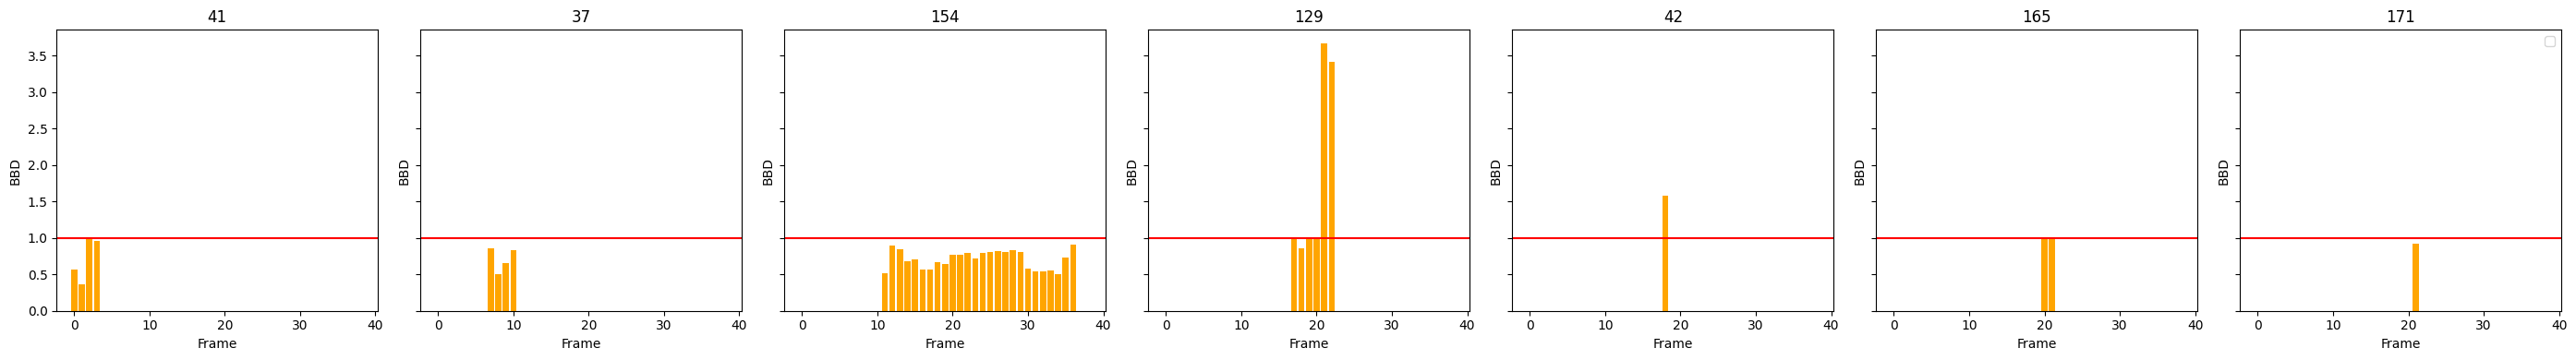

In [15]:
show_metric_for_each_gt_obj(data, 'scene-0061', 'bbd', yline=1.0)

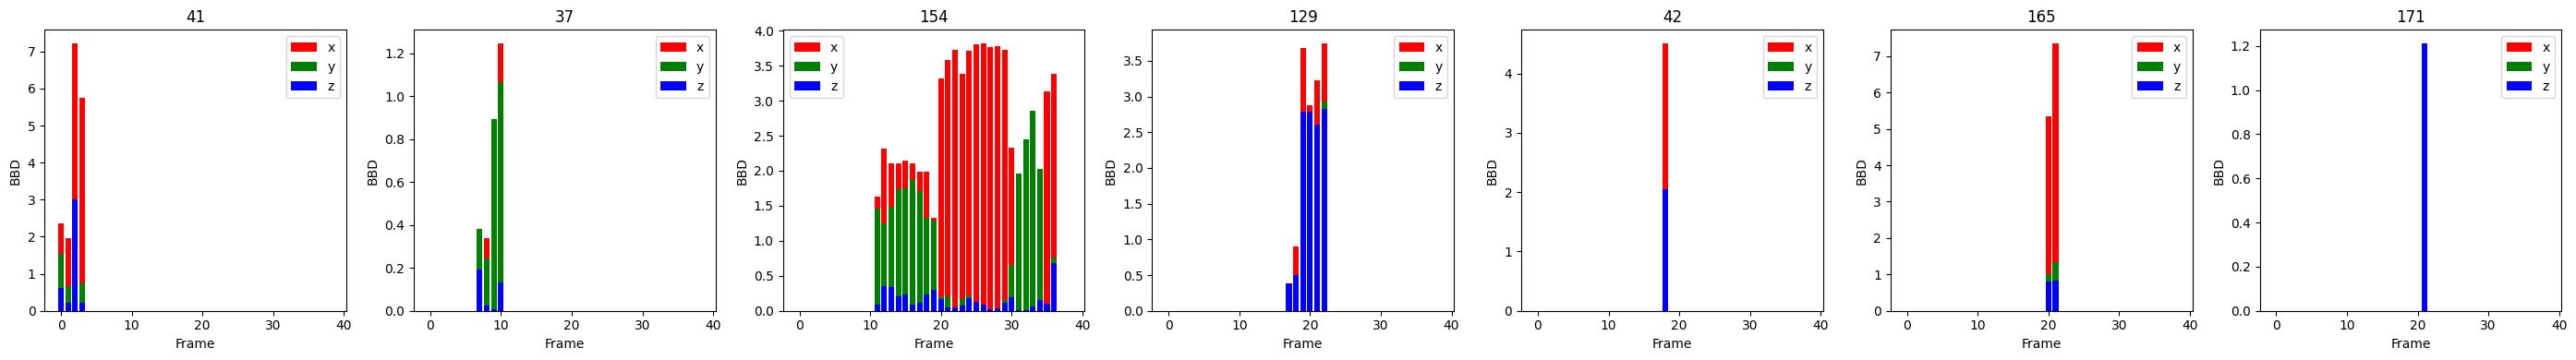

In [44]:
show_metric_for_each_gt_obj(data, 'scene-0061', 'ded')